# 预读取

In [1]:
import h5py
import cv2
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import pickle
import pandas as pd
import copy
import os
from pt_module import StNet,StRefine

In [2]:
colors = plt.cm.viridis(np.linspace(0, 1, 4))
model_dir = './ckpt'
state_name = 'spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt'
state_path = os.path.join(model_dir,state_name)
condition_label=['glass && upright tan','glass && upright chen',
                 'no glass && upright tan','no glass && upright chen',
                 'glass && not upright tan','glass && not upright chen',
                 'no glass && not upright tan','no glass && not upright chen',
                 'glass && indoor daylight tan', 'glass && indoor daylight chen',
                 'no glass && indoor daylight tan','no glass && indoor daylight chen',
                 'glass && only lamp tan','glass && only lamp chen',
                 'no glass && only lamp tan','no glass && only lamp chen',
                 'glass && only external lighting tan','glass && only external lighting chen',
                 'no glass && only external lighting tan','no glass && only external lighting chen',
                 'Normal indoor lighting at night && glass && no mask tan', 'Normal indoor lighting at night && glass && no mask chen',
                 'Normal indoor lighting at night && glass && large camera distance(70cm+) tan','Normal indoor lighting at night && glass && large camera distance(70cm+) chen',
                 'Normal indoor lighting at night && glass && middle camera distance(45-48cm) tan','Normal indoor lighting at night && glass && middle camera distance(45-48cm) chen',
                 'Normal indoor lighting at night && glass && small camera distance(32-35cm) tan','Normal indoor lighting at night && glass && small camera distance(32-35cm) chen',
                 'Normal indoor lighting at night && glass && large inclination angle(45°) tan','Normal indoor lighting at night && glass && large inclination angle(45°) chen',
                 'Normal indoor lighting at night && glass && middle inclination angle(30°) tan','Normal indoor lighting at night && glass && middle inclination angle(30°) chen',
                 'Normal indoor lighting at night && glass && small inclination angle(15°) tan','Normal indoor lighting at night && glass && small inclination angle(15°) chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone chen']
print(len(condition_label))

46


In [3]:
# 读取数据
with open('./gaze_pred_new.pkl', 'rb') as fo:
    tinydict = pickle.load(fo, encoding='bytes')#que
file_names = tinydict['file_name']
file_dict = []
for file_name in file_names:
    file_name = str(file_name).strip('()').split(',')
    # print(file_name)
    for file in file_name:
        if(file!=''):
            # print(file.strip("''").split('/')[4].split('.')[0][40:])
            # print(file.strip("''").split('/')[4].split('.')[0][40:])
            file_dict.append(int(file.strip("''").split('/')[6].split('.')[0][19:]))
print(file_dict)
print(len(file_dict))

with open('/home/hgh/hghData/Datasets/dataset_dict_eve.pkl', 'rb') as fo:
    tinydict2 = pickle.load(fo, encoding='bytes')#que

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 22

In [4]:
def get_condition_number(file_dict):
    if (1 <= file_dict <= 100):
        return 0
    if (101 <= file_dict <= 200):
        return 1
    if (201 <= file_dict <= 300):
        return 2
    if (301 <= file_dict <= 400):
        return 3
    if (401 <= file_dict <= 500):
        return 4
    if (501 <= file_dict <= 600):
        return 5
    if (601 <= file_dict <= 700):
        return 6
    if (701 <= file_dict <= 800):
        return 7
    if (801 <= file_dict <= 850):
        return 8
    if (851 <= file_dict <= 900):
        return 9
    if (901 <= file_dict <= 950):
        return 10
    if (951 <= file_dict <= 1000):
        return 11
    if (1001 <= file_dict <= 1050):
        return 12
    if (1051 <= file_dict <= 1100):
        return 13
    if (1101 <= file_dict <= 1150):
        return 14
    if (1151 <= file_dict <= 1200):
        return 15
    if (1201 <= file_dict <= 1250):
        return 16
    if (1251 <= file_dict <= 1300):
        return 17
    if (1301 <= file_dict <= 1350):
        return 18
    if (1351 <= file_dict <= 1400):
        return 19
    if (1401 <= file_dict <= 1440):
        return -1
    if (1441 <= file_dict <= 1520):
        return 20
    if (1521 <= file_dict <= 1600):
        return 21
    if (1601 <= file_dict <= 1620):
        return 22
    if (1621 <= file_dict <= 1640):
        return 23
    if (1641 <= file_dict <= 1700):
        return 24
    if (1701 <= file_dict <= 1760):
        return 25
    if (1761 <= file_dict <= 1780):
        return 26
    if (1781 <= file_dict <= 1800):
        return 27
    if (1801 <= file_dict <= 1820):
        return 28
    if (1821 <= file_dict <= 1840):
        return 29
    if (1841 <= file_dict <= 1900):
        return 30
    if (1901 <= file_dict <= 1960):
        return 31
    if (1961 <= file_dict <= 1980):
        return 32
    if (1981 <= file_dict <= 2000):
        return 33
    if (2001 <= file_dict <= 2050):
        return 34
    if (2051 <= file_dict <= 2100):
        return 35
    if (2101 <= file_dict <= 2150):
        return 36
    if (2151 <= file_dict <= 2200):
        return 37
    if (2201 <= file_dict <= 2250):
        return 38
    if (2251 <= file_dict <= 2300):
        return 39
    if (2301 <= file_dict <= 2350):
        return 40
    if (2351 <= file_dict <= 2400):
        return 41
    if (2401 <= file_dict <= 2450):
        return 42
    if (2451 <= file_dict <= 2500):
        return 43
    if (2501 <= file_dict <= 2550):
        return 44
    if (2551 <= file_dict <= 2600):
        return 45

In [5]:
ground_truth = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
pred = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
RMat = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(file_dict)):
    number = get_condition_number(file_dict[i])
    ground_truth[number].append(tinydict['label'][i])
    pred[number].append(tinydict['pred_gaze'][i])
    RMat[number].append(tinydict2[i]['R'])

for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    pred[i] = np.vstack(pred[i])
# 将pitchyaw转换成vector
for i in range(len(ground_truth)):
    pred[i] = warp_norm.pitchyaw_to_vector(pred[i])

# 还原注视向量并获取投影点

In [6]:
epi = 0.7
# 将归一化向量还原
org_pred =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(RMat[i])):
        # print(RMat[i][j])
        RMat[i][j][2] *= epi
        org_pred[i].append(np.dot(np.linalg.inv(RMat[i][j]), pred[i][j].T))


In [7]:
pixel_scale_tan = np.array([0.202, 0.224])
pixel_scale_chen = np.array([0.22, 0.235])

pred_gc = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(pred[i])):
        if i%2 == 0:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_tan))
        else:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_chen))
# print(pred_gc[0])

In [8]:
org_tan = np.array([800,0])#tan 1600*825
org_chen = np.array([650,0])#chen 1300*720


pred_gc_org = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    if i%2 == 0:
        pred_gc_org[i] = org_tan + pred_gc[i]
    else:
        pred_gc_org[i] = org_chen + pred_gc[i]

In [9]:
# calculate standard deviation distance
l2 = []
for i in range(8):
    l2.append(np.mean(np.linalg.norm(ground_truth[i]-pred_gc_org[i],axis = 1)))
print(l2)
print(np.mean(l2[:4]))

[232.7086770185017, 178.49550357180385, 298.93763653634306, 257.4233922745547, 413.2779736106697, 368.19632637433193, 522.2264212964643, 360.5576321429281]
241.89130235030086


In [10]:
pred_errors=[]
pred_xerrors=[]
pred_yerrors=[]
for i in range(46):
    total_errors=0
    total_xerrors = 0
    total_yerrors = 0
    for j in range(len(pred[i])):
        total_errors=total_errors+((pred_gc_org[i][j][0]-ground_truth[i][j][0])**2+(pred_gc_org[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors=total_xerrors+abs(pred_gc_org[i][j][0]-ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(pred_gc_org[i][j][1] - ground_truth[i][j][1])
    pred_errors.append(total_errors/(len(pred[i])))
    pred_xerrors.append(total_xerrors / (len(pred[i])))
    pred_yerrors.append(total_yerrors / (len(pred[i])))
pred_xerrors_cm=[]
pred_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_tan[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_tan[1])
    else:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_chen[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_chen[1])
# print(pred_errors)
print('pred errors:')
print(pred_xerrors_cm)
print(pred_yerrors_cm)


pred errors:
[3.2668877308863675, 2.7870886793445817, 2.058691660094138, 2.934063589489802, 7.175020120165277, 4.81793739476321, 6.83300262115748, 4.2784541974692125, 3.9242220740405402, 11.372633045029577, 4.797293704072832, 6.627254314641834, 12.530465404208103, 8.643535190585133, 1.4733147908014104, 3.555809276757117, 10.281536041930572, 2.483076177083891, 2.516139157756458, 3.3255689335734786, 5.588665236552228, 6.399745681873793, 6.917346046201569, 2.7112664852231276, 7.946641884131201, 5.579759262121788, 7.12441799940452, 3.9394327151847786, 5.2606315743628045, 4.752710985595452, 10.027977474494909, 4.418202027968008, 7.3277953628883, 4.260251829543093, 5.772728554141572, 4.710583958180155, 21.165943093861216, 14.625699787806585, 5.029281066534041, 2.742545167097456, 20.50552106229744, 17.37307612433581, 3.2672133035923174, 3.2869487987244663, 24.87371808823419, 12.531151596522749]
[3.019183048998251, 2.3716373996278444, 6.121285968674202, 4.650475142923379, 3.2695245178370183, 6

In [11]:
in_screen_net = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= pred_gc_org[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= pred_gc_org[i][j][1] <= 825 + 0.05 * 825):
                in_screen_net[i].append(1)
            else:
                in_screen_net[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= pred_gc_org[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= pred_gc_org[i][j][1] <= 720 + 0.05 * 720):
                in_screen_net[i].append(1)
            else:
                in_screen_net[i].append(0)
# print(in_screen)

device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_net[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.99, 0.88, 0.7261904761904762, 0.64, 0.8585858585858586, 0.6597938144329897, 0.6417910447761194, 0.5961538461538461, 0.98, 0.5510204081632653, 0.7, 0.54, 0.86, 0.22, 0.94, 0.76, 0.8, 0.94, 0.8, 0.9, 1.0, 0.725, 0.95, 1.0, 1.0, 0.8333333333333334, 0.07142857142857142, 0.6, 0.0, 0.95, 0.0, 0.48333333333333334, 1.0, 1.0, 0.98, 0.86, 0.06000000000000005, 0.07999999999999996, 0.78, 0.96, 0.07999999999999996, 0.06000000000000005, 0.92, 0.9, 0.9, 0.1685393258426966]


# 使用sc模块处理

In [12]:
# SC Module
gtr=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
aver_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
offset=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    total_truth=[0,0]
    total_pred=[0,0]
    for j in range(int(len(pred[i])/2)):
        total_truth=total_truth + ground_truth[i][j]
        total_pred = total_pred + pred_gc_org[i][j]
    if i%2==0:
        gtr[i] = [800, 412.5]
    else:
        gtr[i] = [650, 360]
    aver_pred[i] = total_pred / int(len(pred[i])/2)
    if i < 8:
        print(aver_pred)
        offset[i] = aver_pred[i % 4] - gtr[i]
    elif 8 <= i < 20:
        offset[i] = aver_pred[i] - gtr[i]
    else:
        offset[i] = aver_pred[20+i%2] - gtr[i]

[array([789.92045821, 321.03762104]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([789.92045821, 321.03762104]), array([555.25545515, 291.63652758]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([789.92045821, 321.03762104]), array([555.25545515, 291.63652758]), array([523.01490083, 706.62459884]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([789.92045821, 321.03762104]), array([555.25545515, 291.63652758]), array([523.01490083, 706.62459884]), array([669.77220653, 548.55158031]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

In [13]:
refine_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    refine_pred[i]=pred_gc_org[i] - offset[i]


In [14]:
SC_errors=[]
SC_xerrors=[]
SC_yerrors=[]
for i in range(46):
    total_errors = 0
    total_xerrors = 0
    total_yerrors = 0
    for j in range(len(pred[i])):
        total_errors=total_errors+((refine_pred[i][j][0]-ground_truth[i][j][0])**2+(refine_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors = total_xerrors + abs(refine_pred[i][j][0] - ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(refine_pred[i][j][1] - ground_truth[i][j][1])
    SC_errors.append(total_errors/len(pred[i]))
    SC_xerrors.append(total_xerrors / len(pred[i]))
    SC_yerrors.append(total_yerrors / len(pred[i]))
SC_xerrors_cm=[]
SC_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        SC_xerrors_cm.append(SC_xerrors[i] * 0.1 * pixel_scale_tan[0])
        SC_yerrors_cm.append(SC_yerrors[i] * 0.1 * pixel_scale_tan[1])
    else:
        SC_xerrors_cm.append(SC_xerrors[i] * 0.1 * pixel_scale_chen[0])
        SC_yerrors_cm.append(SC_yerrors[i] * 0.1 * pixel_scale_chen[1])
print('SC errors:')
# print(SC_errors_cm)
print(SC_xerrors_cm)
print(SC_yerrors_cm)


SC errors:
[3.1447236843779156, 2.134626686875571, 3.699931325314163, 2.9109815215770567, 7.109191763544567, 4.104262668917623, 10.721136375092897, 4.085905313213266, 3.6970071475047193, 3.8988467316022235, 3.2445312871027117, 2.8309867871637264, 9.916556628545173, 7.988626289302047, 2.0497263108921207, 3.711126855206731, 10.360706703469994, 2.224514923878624, 3.1757563997735287, 2.239604557434776, 5.5091567824299945, 4.3979548687702845, 6.99875508438948, 3.036107378397235, 7.886804268327892, 3.3524366981426925, 7.188529730622351, 2.4828607618909913, 5.170875150657839, 4.332024983602346, 9.738223843655238, 2.6514014592087607, 7.282917151035821, 2.4351059032186932, 5.8851789509021755, 3.1050829184760214, 21.61472521238603, 12.174507103968185, 4.964659549422353, 2.5420453851976967, 20.954303180822254, 14.343508985272166, 3.180245673806142, 2.100582198143545, 25.322500206759006, 11.19962635195913]
[3.0280852535991, 2.024870648488924, 1.6965361480752836, 1.4754176151257499, 4.4183077855006

In [29]:
# 使用pandas的read_csv函数读取数据
df = pd.read_csv(pd.compat.StringIO(SC_xerrors_cm))
excel_file = "output.xlsx"
df.to_excel(excel_file, index=False)

print(f"数据已成功写入 {excel_file}")

AttributeError: module 'pandas.compat' has no attribute 'StringIO'

In [15]:
in_screen_SC = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= refine_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= refine_pred[i][j][1] <= 825 + 0.05 * 825):
                in_screen_SC[i].append(1)
            else:
                in_screen_SC[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= refine_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= refine_pred[i][j][1] <= 720 + 0.05 * 720):
                in_screen_SC[i].append(1)
            else:
                in_screen_SC[i].append(0)
# print(in_screen)


In [16]:
device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_SC[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.99, 0.94, 0.9642857142857143, 0.82, 0.8080808080808081, 0.6597938144329897, 0.7014925373134329, 0.4423076923076923, 1.0, 0.8163265306122449, 0.96, 0.96, 0.94, 0.98, 0.86, 0.72, 0.84, 0.94, 0.88, 0.96, 1.0, 0.7125, 1.0, 0.3, 1.0, 0.8333333333333334, 0.07142857142857142, 0.75, 0.0, 0.9, 0.0, 0.03333333333333333, 1.0, 0.5, 0.96, 0.4, 0.06000000000000005, 0.72, 0.76, 0.62, 0.07999999999999996, 0.38, 0.9, 0.56, 0.92, 0.3595505617977528]


# 使用st模块处理

In [17]:
history=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(int(len(refine_pred[i]) / 2)):
        history[i].append(np.array(refine_pred[i][j]))
    # print(np.array(history[i]))
# create_history_gaze_path_map(history[0])

In [18]:
#PT Module
st_refine_tan = StRefine(StNet_path=state_path, full_screen_size=(1600, 825))
st_refine_chen = StRefine(StNet_path=state_path, full_screen_size=(1300, 720))
# result,valid=st_refine.refine(np.array(refine_pred[0][0]),history[0])
# print(refine_pred[0][0])
# print(result.detach().cpu().numpy())

StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py
StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py


In [19]:
final_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(refine_pred[i])):
        if i < 20:
            if i % 2 == 0:
                output, valid = st_refine_tan.refine(np.array(refine_pred[i][j]), np.array(history[i % 4]))
            else:
                output, valid = st_refine_chen.refine(np.array(refine_pred[i][j]), np.array(history[i % 4]))
        else:
            if i % 2 == 0:
                output, valid = st_refine_tan.refine(np.array(refine_pred[i][j]), np.array(history[i % 2]))
            else:
                output, valid = st_refine_chen.refine(np.array(refine_pred[i][j]), np.array(history[i % 2]))

        # if(i==2 or i==3):
        #     output, valid = st_refine.refine(np.array(refine_pred[i][j]), np.array(history[i-2]))
        # else:
        #     output, valid = st_refine.refine(np.array(refine_pred[i][j]), np.array(history[i]))
        # print(refine_pred[i][j],output,valid)
        # print(output.detach().cpu().numpy())
        if valid:
            final_pred[i].append(output.detach().cpu().numpy())
        else:
            final_pred[i].append(output)
    # print(np.array(final_pred[i]).shape)


/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [20]:
aver_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

for i in range(46):
    total_xy=[0,0]
    for j in range(len(pred[i])):
        total_xy=total_xy+final_pred[i][j]
    aver_pred[i]=total_xy/len(pred[i])
# print(aver_pred)

In [21]:
PT_errors=[]
PT_xerrors=[]
PT_yerrors=[]
for i in range(46):
    total_errors = 0
    total_xerrors = 0
    total_yerrors = 0

    for j in range(len(pred[i])):
        total_errors=total_errors+((final_pred[i][j][0]-ground_truth[i][j][0])**2+(final_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors = total_xerrors +abs(final_pred[i][j][0] - ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(final_pred[i][j][1] - ground_truth[i][j][1])
    PT_errors.append(total_errors/len(pred[i]))
    PT_xerrors.append(total_xerrors / len(pred[i]))
    PT_yerrors.append(total_yerrors / len(pred[i]))

PT_xerrors_cm=[]
PT_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        PT_xerrors_cm.append(PT_xerrors[i] * 0.1*pixel_scale_tan[0])
        PT_yerrors_cm.append(PT_yerrors[i] * 0.1*pixel_scale_tan[1])
    else:
        PT_xerrors_cm.append(PT_xerrors[i] * 0.1*pixel_scale_chen[0])
        PT_yerrors_cm.append(PT_yerrors[i] * 0.1*pixel_scale_chen[1])
print('PT errors:')
# print(PT_magnify_errors_cm)
print(PT_xerrors_cm)
print(PT_yerrors_cm)


PT errors:
[2.264031153625275, 2.1339104428700844, 2.62653533893523, 2.9090909544044266, 7.398697507432954, 4.10117726206763, 10.438769318215183, 4.124192395434184, 3.2007836765136717, 3.8978465100948414, 2.460921188845392, 2.9537691354080575, 10.468617415683012, 7.992614543313938, 1.4778295029556758, 3.7776980157995497, 10.906184594260496, 2.2076747235745415, 3.1045166048715616, 2.215703631352667, 5.276615895609607, 4.422023393529533, 7.249568555908203, 3.0301272410461753, 7.962528012084962, 3.357703325069512, 7.188529730622351, 2.50362569826623, 5.170875150657839, 4.340068909420241, 9.738223843655238, 2.650074289956179, 7.303962129820424, 2.438943133400588, 6.4233283185000225, 3.1102881912800195, 23.4548740945722, 12.178766912815854, 5.22694908501516, 2.535913848323974, 22.535962584573717, 14.356976291449785, 3.3976590383972733, 2.104600780271138, 25.389669918735684, 11.210500190699356]
[2.7579587316663847, 1.9229190764805553, 1.725822073290336, 1.5436337592042175, 4.7688443949193715

In [22]:
in_screen_PT = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= final_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= final_pred[i][j][1] <= 825 + 0.05 * 825):
                in_screen_PT[i].append(1)
            else:
                in_screen_PT[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= final_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= final_pred[i][j][1] <= 720 + 0.05 * 720):
                in_screen_PT[i].append(1)
            else:
                in_screen_PT[i].append(0)
# print(in_screen)
device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_PT[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.99, 0.94, 0.9642857142857143, 0.82, 0.8080808080808081, 0.6597938144329897, 0.7014925373134329, 0.4423076923076923, 1.0, 0.8163265306122449, 0.96, 0.96, 0.94, 0.98, 0.86, 0.72, 0.84, 0.94, 0.88, 0.96, 1.0, 0.7125, 1.0, 0.3, 1.0, 0.8333333333333334, 0.07142857142857142, 0.75, 0.0, 0.9, 0.0, 0.03333333333333333, 1.0, 0.5, 0.96, 0.4, 0.06000000000000005, 0.72, 0.76, 0.62, 0.07999999999999996, 0.38, 0.9, 0.56, 0.92, 0.3595505617977528]


# magnifiy（revoke）

In [23]:
# for i in range(46):
#     for j in range(len(pred[i])):
#         if i % 2 == 0:
#             final_pred[i][j] = pixel_scale_tan / 2 + (final_pred[i][j] - pixel_scale_tan / 2)/0.7
#         else:
#             final_pred[i][j] = pixel_scale_chen / 2 + (final_pred[i][j] - pixel_scale_chen / 2)/0.7

In [24]:
# PT_magnify_errors=[]
# PT_magnify_xerrors=[]
# PT_magnify_yerrors=[]
# for i in range(46):
#     total_errors = 0
#     total_xerrors = 0
#     total_yerrors = 0

#     for j in range(len(pred[i])):
#         total_errors=total_errors+((final_pred[i][j][0]-ground_truth[i][j][0])**2+(final_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
#         total_xerrors = total_xerrors +abs(final_pred[i][j][0] - ground_truth[i][j][0])
#         total_yerrors = total_yerrors + abs(final_pred[i][j][1] - ground_truth[i][j][1])
#     PT_magnify_errors.append(total_errors/len(pred[i]))
#     PT_magnify_xerrors.append(total_xerrors / len(pred[i]))
#     PT_magnify_yerrors.append(total_yerrors / len(pred[i]))

# PT_magnify_xerrors_cm=[]
# PT_magnify_yerrors_cm=[]
# for i in range(46):
#     if i % 2 == 0:
#         PT_magnify_xerrors_cm.append(PT_magnify_xerrors[i] * 0.1*pixel_scale_tan[0])
#         PT_magnify_yerrors_cm.append(PT_magnify_yerrors[i] * 0.1*pixel_scale_tan[1])
#     else:
#         PT_magnify_xerrors_cm.append(PT_magnify_xerrors[i] * 0.1*pixel_scale_chen[0])
#         PT_magnify_yerrors_cm.append(PT_magnify_yerrors[i] * 0.1*pixel_scale_chen[1])
# print('PT errors:')
# # print(PT_magnify_errors_cm)
# print(PT_magnify_xerrors_cm)
# print(PT_magnify_yerrors_cm)


In [25]:
# in_screen_PT = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
# for i in range(46):
#     for j in range(len(pred[i])):
#         if i%2==0:#tan
#             if (0 - 0.05 * 1600 <= final_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= final_pred[i][j][1] <= 825 + 0.05 * 825):
#                 in_screen_PT[i].append(1)
#             else:
#                 in_screen_PT[i].append(0)
#         else:
#             if (0 - 0.05 * 1300 <= final_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= final_pred[i][j][1] <= 720 + 0.05 * 720):
#                 in_screen_PT[i].append(1)
#             else:
#                 in_screen_PT[i].append(0)
# # print(in_screen)

In [26]:
# device_level_accuracy=[]
# for i in range(46):
#     total_in=0
#     for j in range(len(pred[i])):
#         total_in=total_in+in_screen_PT[i][j]
#     device_level_accuracy.append(total_in/len(pred[i]))
#     if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
#         device_level_accuracy[i]=1-device_level_accuracy[i]
# print(device_level_accuracy)

# 展示

In [31]:
import pandas as pd
data = {
    'pred_xerrors_cm':pred_xerrors_cm,
    'pred_yerrors_cm':pred_yerrors_cm,
    'SC_xerrors_cm':SC_xerrors_cm,
    'SC_yerrors_cm':SC_yerrors_cm,
    'PT_xerrors_cm':PT_xerrors_cm,
    'PT_yerrors_cm':PT_yerrors_cm,
    'device_level_accuracy':device_level_accuracy
}
df = pd.DataFrame(data)
df.to_excel('./new_example.xlsx', index=False)



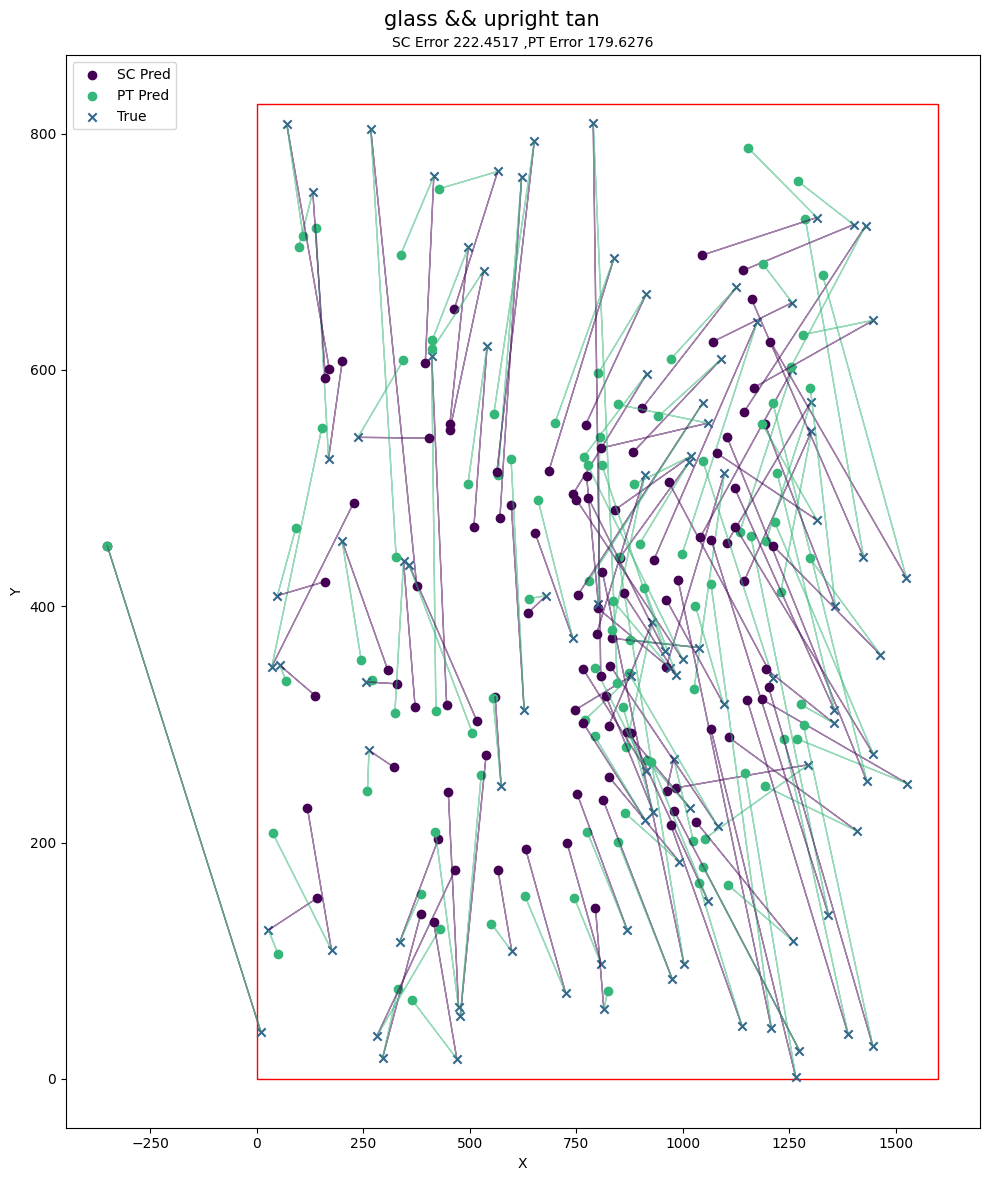

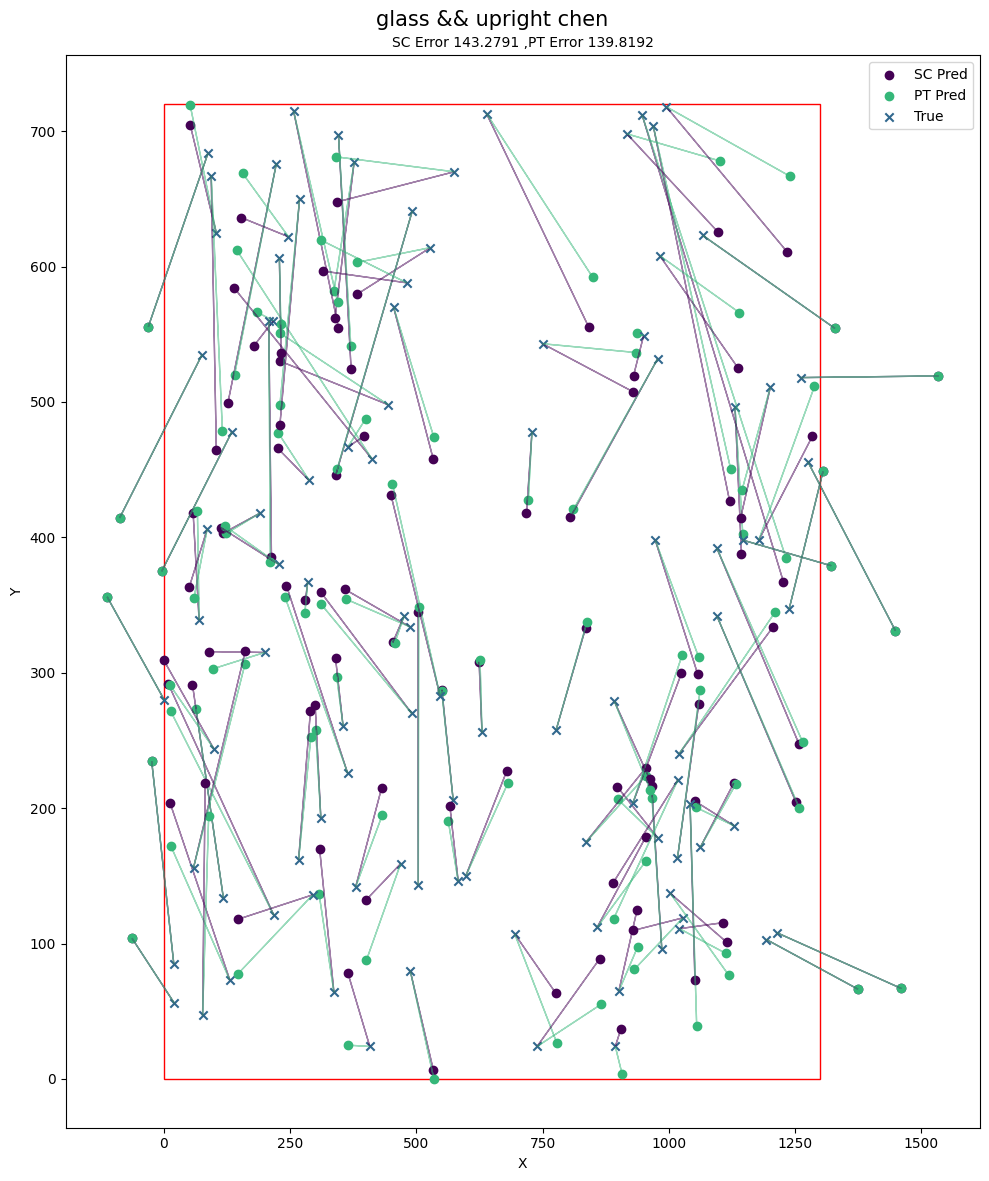

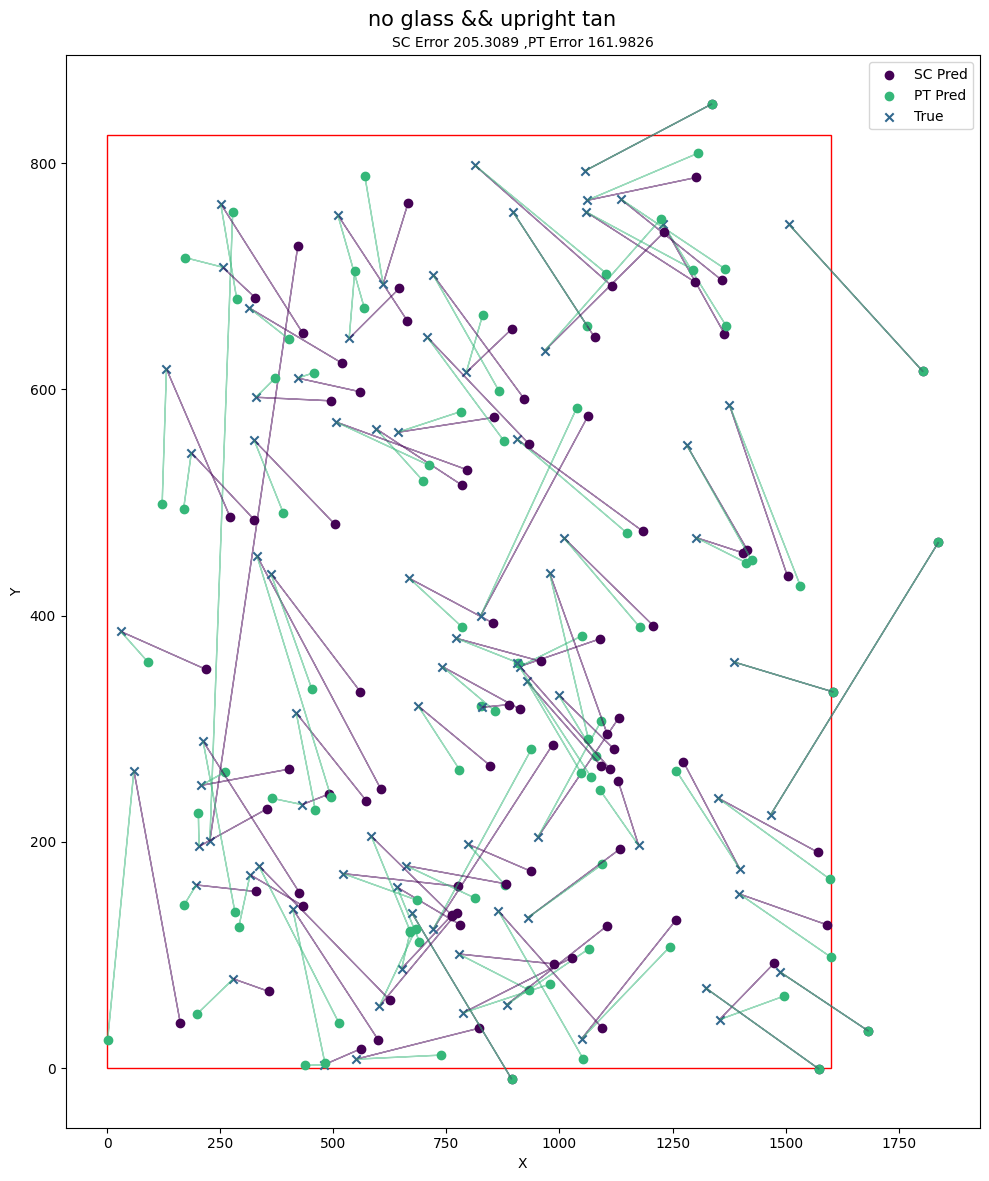

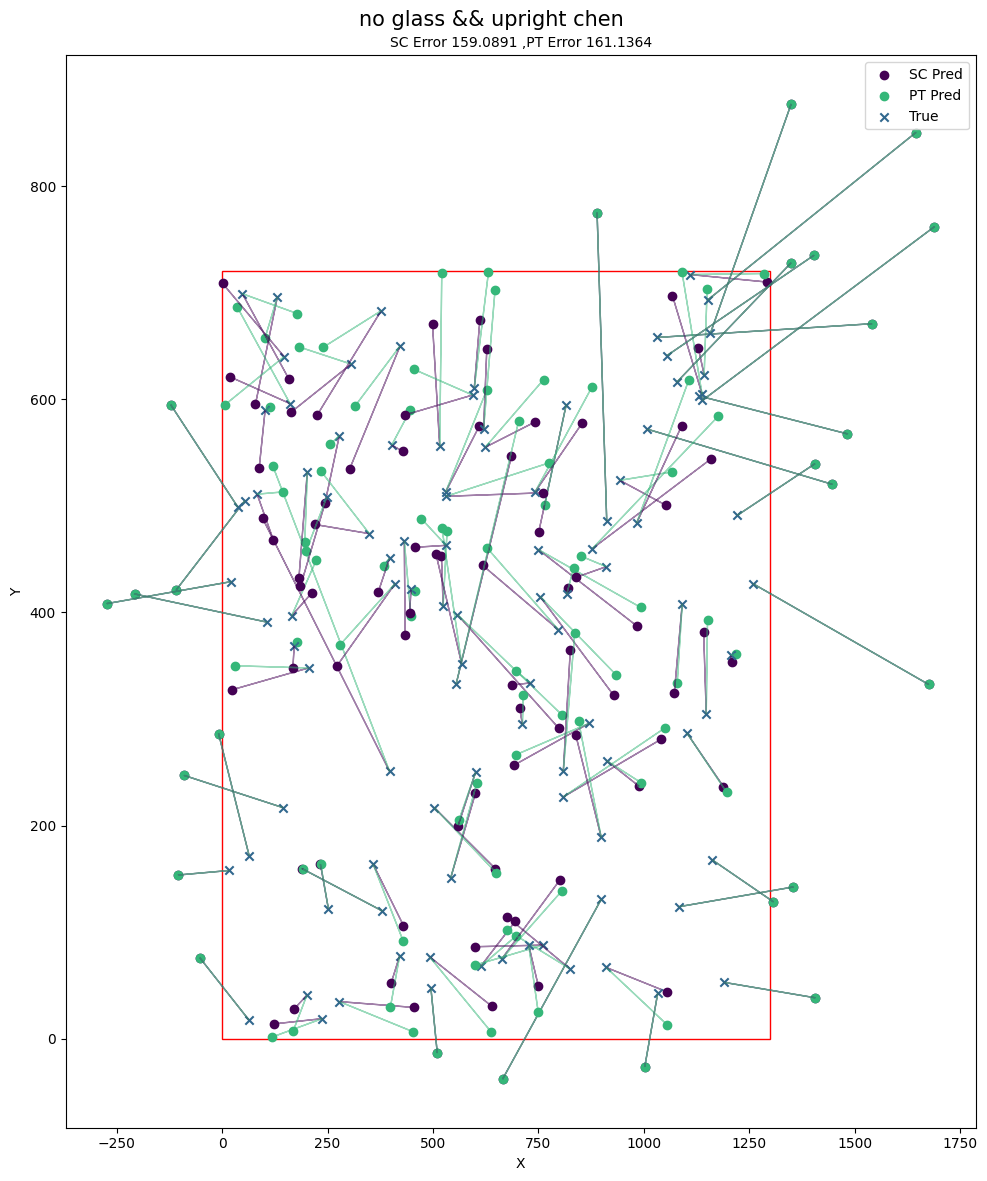

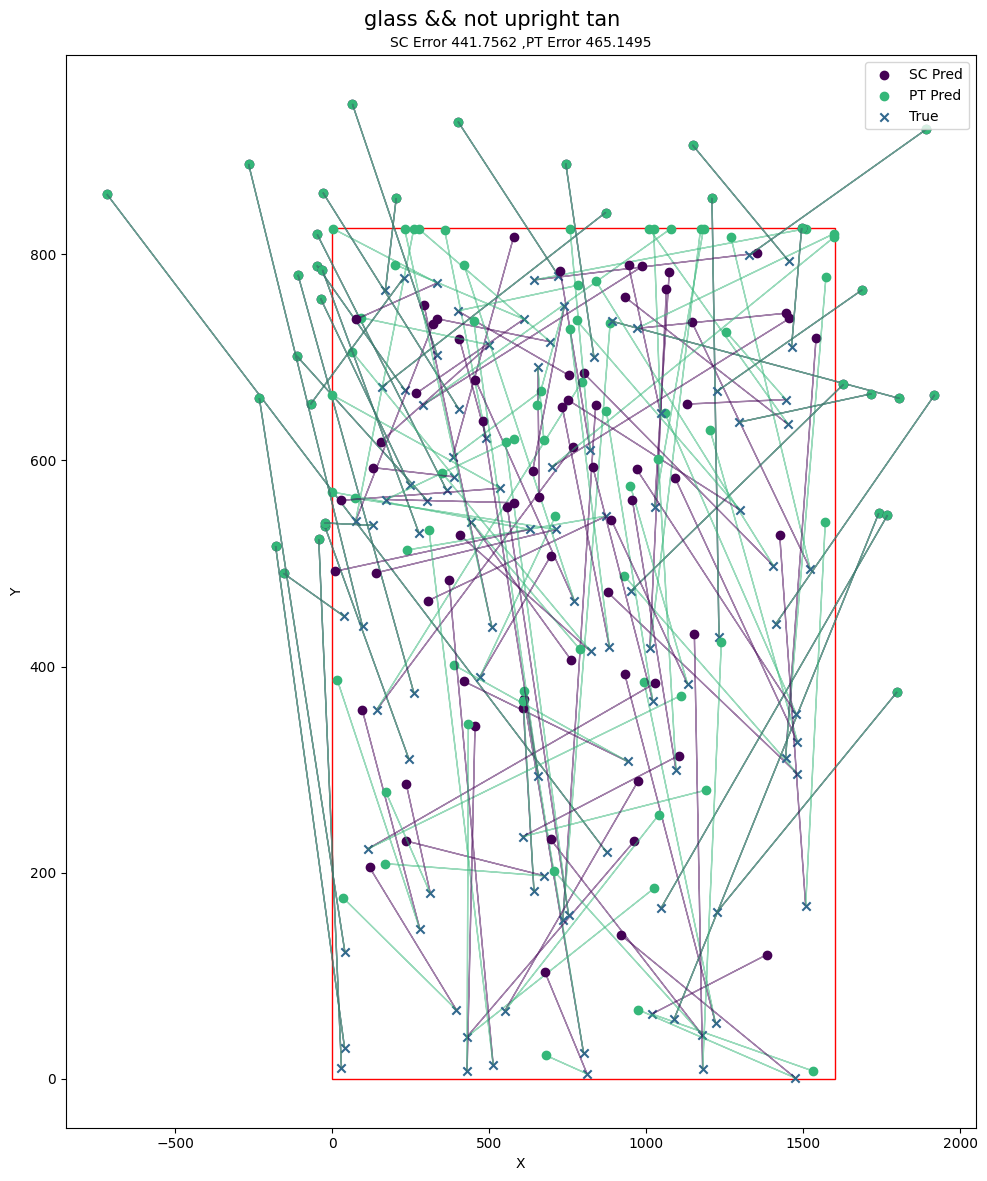

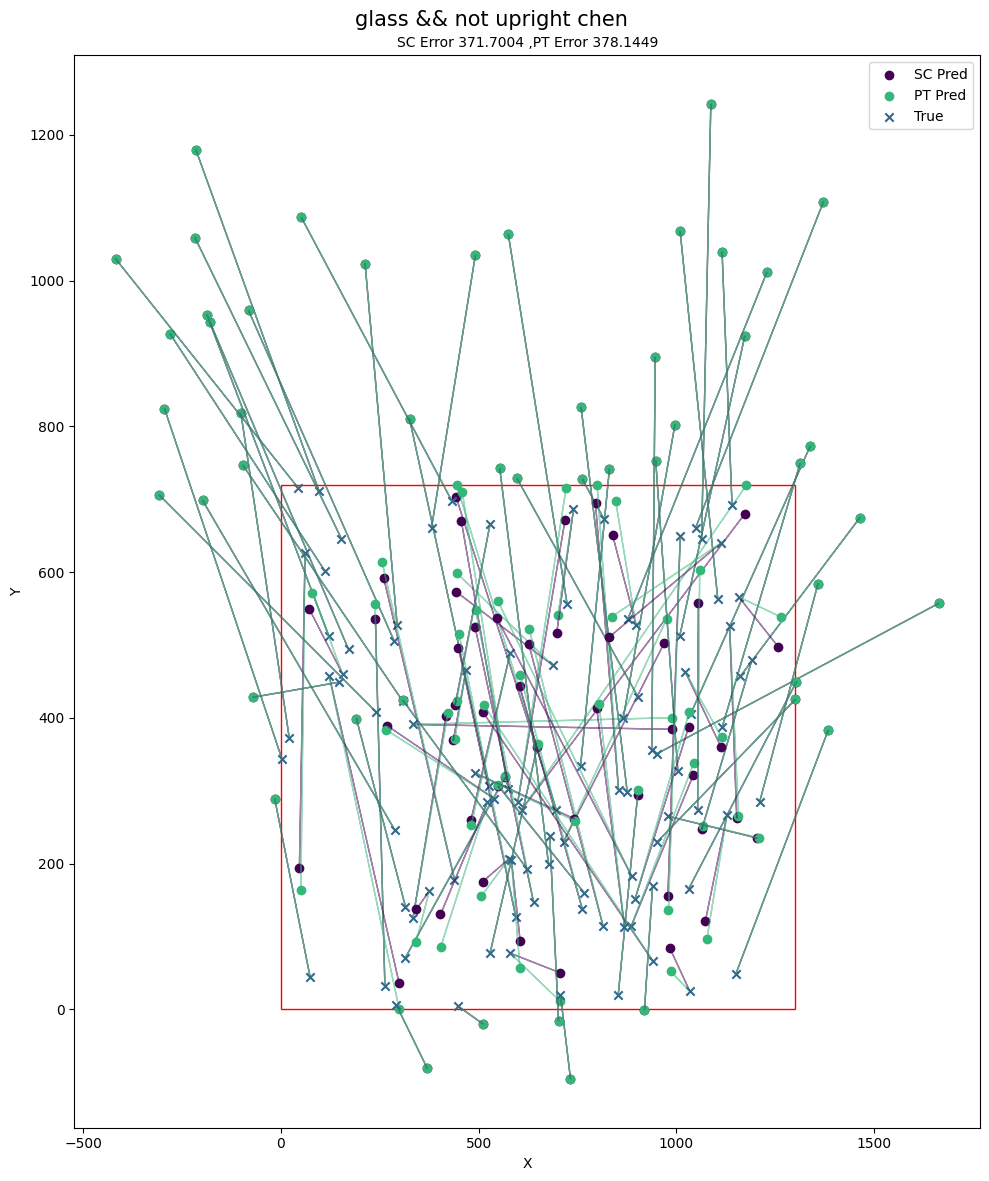

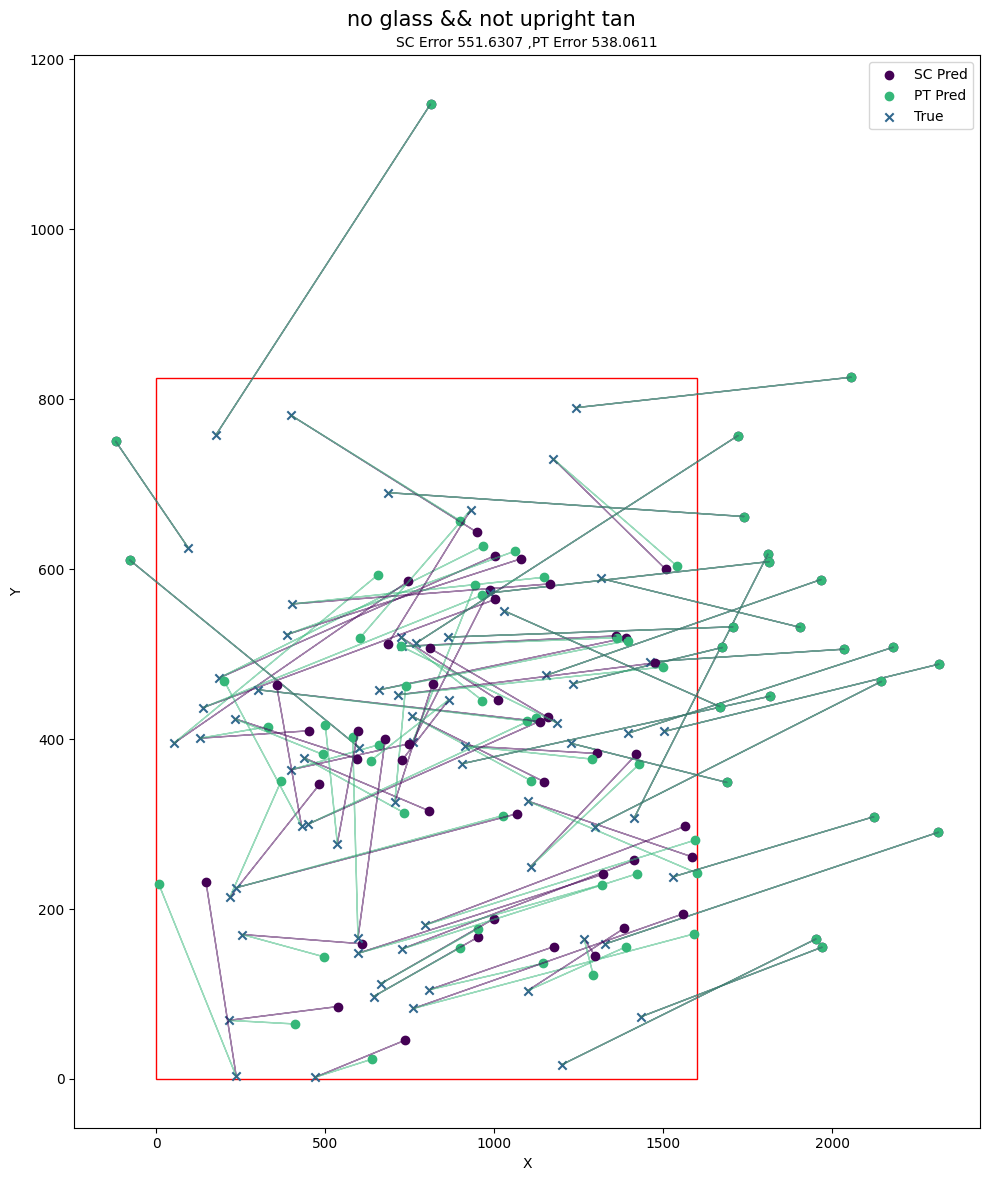

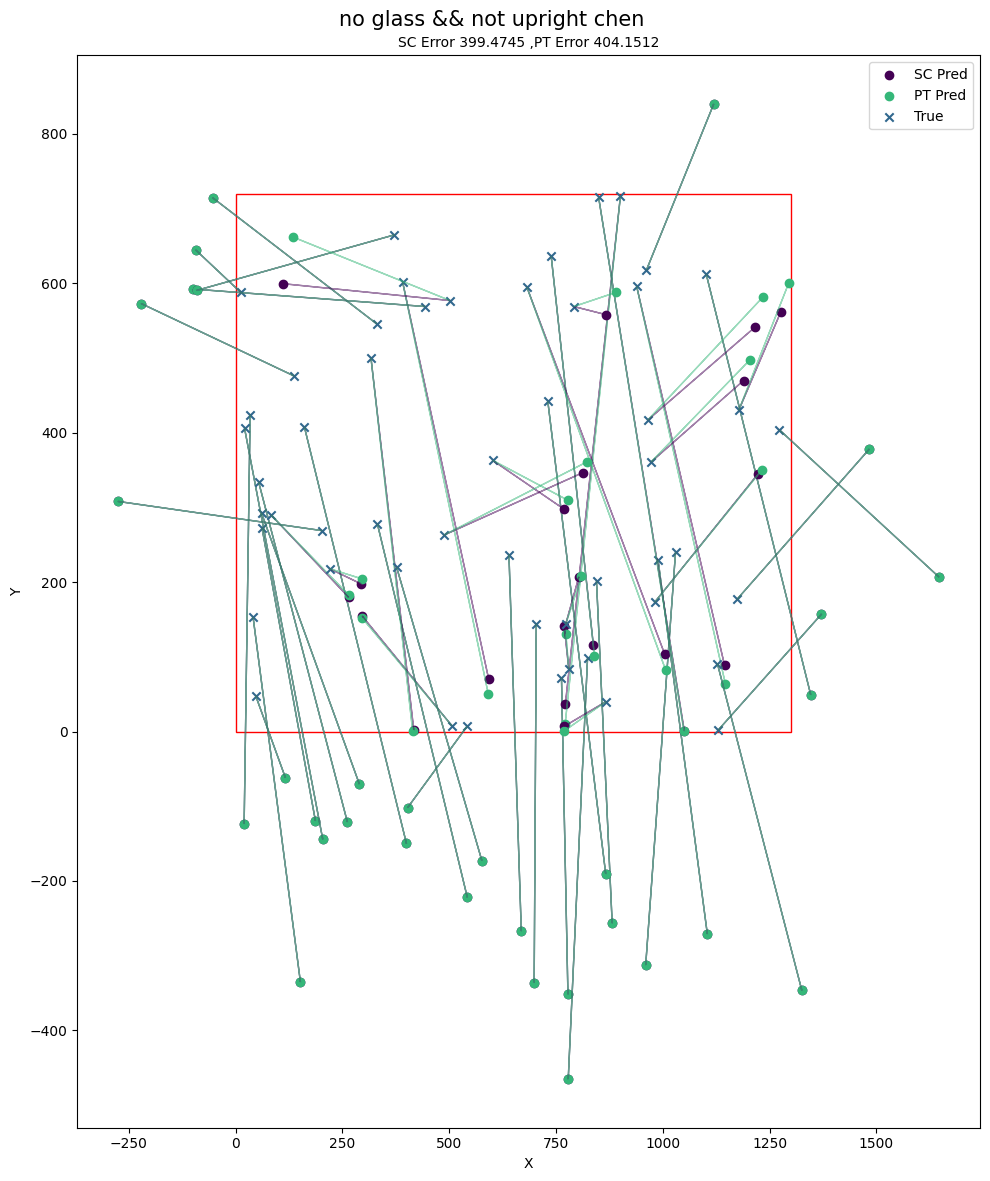

In [28]:
for i in range(8):
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(pred[i])):
        # plt.scatter(pred_gc_org[i][j][0], pred_gc_org[i][j][1], marker='o', color=colors[3], label=f'Pred')
        plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[1], label=f'True')
        plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.title(f'SC Error {SC_errors[i]:.4f} ,PT Error {PT_errors[i]:.4f}', fontsize=10)
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    plt.show()